In [8]:
from compare import *
from lava_generator import *
from xai import latent_space_display_mark

In [9]:
vae = VAE.load("trained_models/VAE")
cnn = load_model("trained_models/CNN/classifier.h5")
xai = xai_model(vae.decoder, cnn, input_shape=(10,))

# input images
# samples_test, sample_labels_test = load_samples_for_test_folder(img_dir='./contrib/DLFuzz/MNIST/seeds_50')
samples_test, sample_labels_test = load_samples_for_test(200)

# prepare
view_samples = samples_test
view_sample_labels = sample_labels_test
# view_samples = samples
# view_sample_labels = sample_labels

x_view = np.reshape(view_samples, (-1, 784))
y_view_onehot = tf.one_hot(tf.constant(view_sample_labels), depth=10).numpy()
h_view = vae.encoder.predict(x_view)

K.set_learning_phase(0)
dlfuzz = DLFuzz(cnn)

7/7 [==============================] - 0s 2ms/step


/opt/anaconda3/envs/bachelor/lib/python3.9/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


  0%|                                                   | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                          | 1/200 [00:17<57:57, 17.47s/it]

1/1 [==============================] - 0s 24ms/step


  1%|▍                                          | 2/200 [00:34<56:59, 17.27s/it]

1/1 [==============================] - 0s 23ms/step


  2%|▌                                        | 3/200 [00:55<1:02:40, 19.09s/it]

1/1 [==============================] - 0s 23ms/step


  2%|▊                                          | 4/200 [01:12<59:28, 18.21s/it]

1/1 [==============================] - 0s 23ms/step


  2%|█                                          | 5/200 [01:29<57:14, 17.61s/it]

1/1 [==============================] - 0s 22ms/step


  3%|█▎                                         | 6/200 [01:45<55:56, 17.30s/it]

1/1 [==============================] - 0s 22ms/step


  4%|█▌                                         | 7/200 [02:01<54:17, 16.88s/it]

1/1 [==============================] - 0s 23ms/step


  4%|█▋                                         | 8/200 [02:18<54:06, 16.91s/it]

1/1 [==============================] - 0s 22ms/step


  4%|█▉                                         | 9/200 [02:35<53:37, 16.85s/it]

1/1 [==============================] - 0s 23ms/step


  5%|██                                        | 10/200 [02:52<53:09, 16.79s/it]

1/1 [==============================] - 0s 22ms/step


  6%|██▎                                       | 11/200 [03:08<52:22, 16.63s/it]

1/1 [==============================] - 0s 23ms/step


  6%|██▌                                       | 12/200 [03:24<51:29, 16.43s/it]

1/1 [==============================] - 0s 23ms/step


  6%|██▋                                       | 13/200 [03:40<50:51, 16.32s/it]

1/1 [==============================] - 0s 22ms/step


  7%|██▉                                       | 14/200 [03:57<50:53, 16.42s/it]

1/1 [==============================] - 0s 22ms/step


  8%|███▏                                      | 15/200 [04:13<50:11, 16.28s/it]

1/1 [==============================] - 0s 73ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


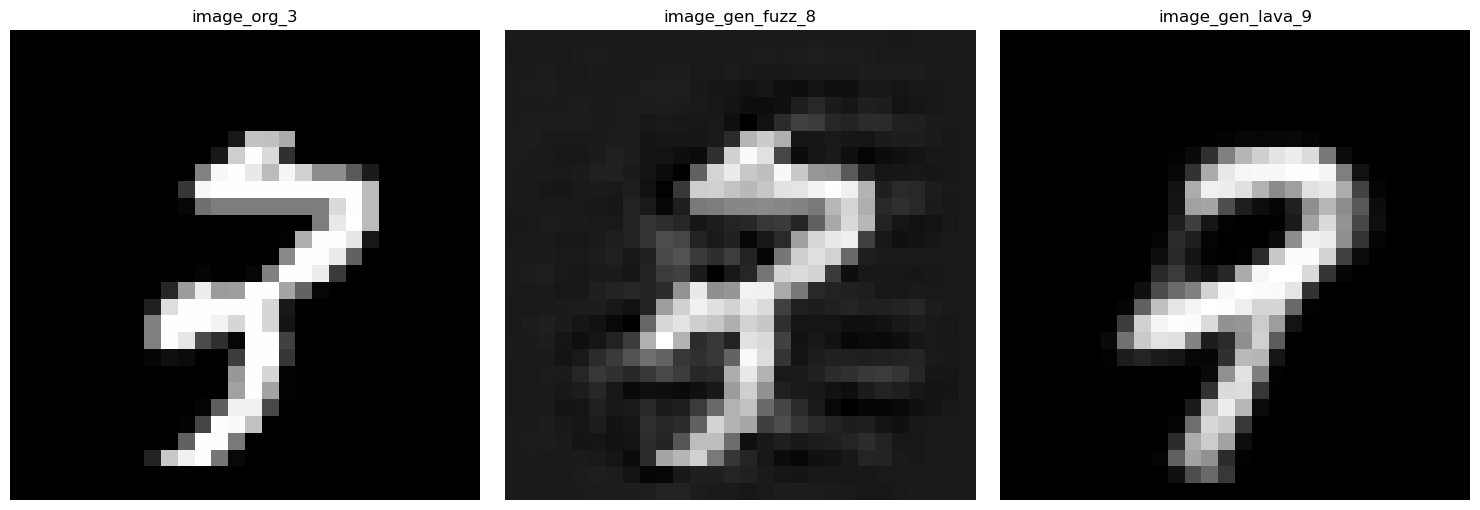

1/1 [==============================] - 0s 21ms/step


  8%|███▎                                      | 16/200 [04:16<37:46, 12.32s/it]

d_fuzz: 0.28407683968544006
d_lava: 1.1517493724822998
kl_fuzz: 0.9027416706085205
kl_lava: inf
ws_fuzz: 0.0014937018616420776
ws_lava: 0.00015534453963061718
js_fuzz: 0.4976504147052765
js_lava: inf
ce_fuzz: 0.902741551399231
ce_lava: inf
mse_fuzz: 5.193667220737552e-06
mse_lava: 2.3071395389706595e-06
1/1 [==============================] - 0s 22ms/step


  8%|███▌                                      | 17/200 [04:32<41:16, 13.53s/it]

1/1 [==============================] - 0s 22ms/step


  9%|███▊                                      | 18/200 [04:48<43:00, 14.18s/it]

1/1 [==============================] - 0s 23ms/step


 10%|███▉                                      | 19/200 [05:04<44:17, 14.68s/it]

1/1 [==============================] - 0s 22ms/step


 10%|████▏                                     | 20/200 [05:20<45:07, 15.04s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 96
1/1 [==============================] - 0s 22ms/step


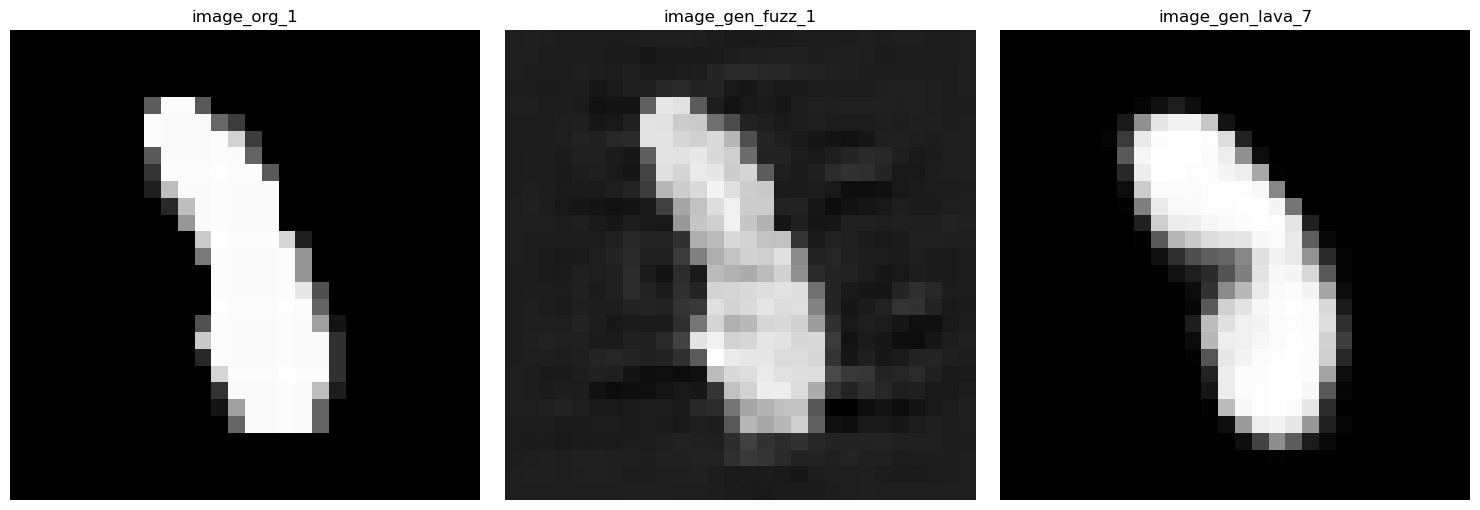

1/1 [==============================] - 0s 21ms/step


 10%|████▍                                     | 21/200 [05:35<45:32, 15.26s/it]

d_fuzz: 0.2731895446777344
d_lava: 1.3498682975769043
kl_fuzz: 0.7993460893630981
kl_lava: inf
ws_fuzz: 0.0013902223624371593
ws_lava: 0.00024062817017300912
js_fuzz: 0.408456951379776
js_lava: inf
ce_fuzz: 0.7993460893630981
ce_lava: inf
mse_fuzz: 3.7375098145275842e-06
mse_lava: 1.9090880414296407e-06
1/1 [==============================] - 0s 23ms/step


 11%|████▌                                     | 22/200 [05:51<45:32, 15.35s/it]

1/1 [==============================] - 0s 21ms/step


 12%|████▊                                     | 23/200 [06:07<45:50, 15.54s/it]

1/1 [==============================] - 0s 22ms/step


 12%|█████                                     | 24/200 [06:23<45:41, 15.58s/it]

1/1 [==============================] - 0s 21ms/step
Misclassification achieved at iteration 1
1/1 [==============================] - 0s 22ms/step


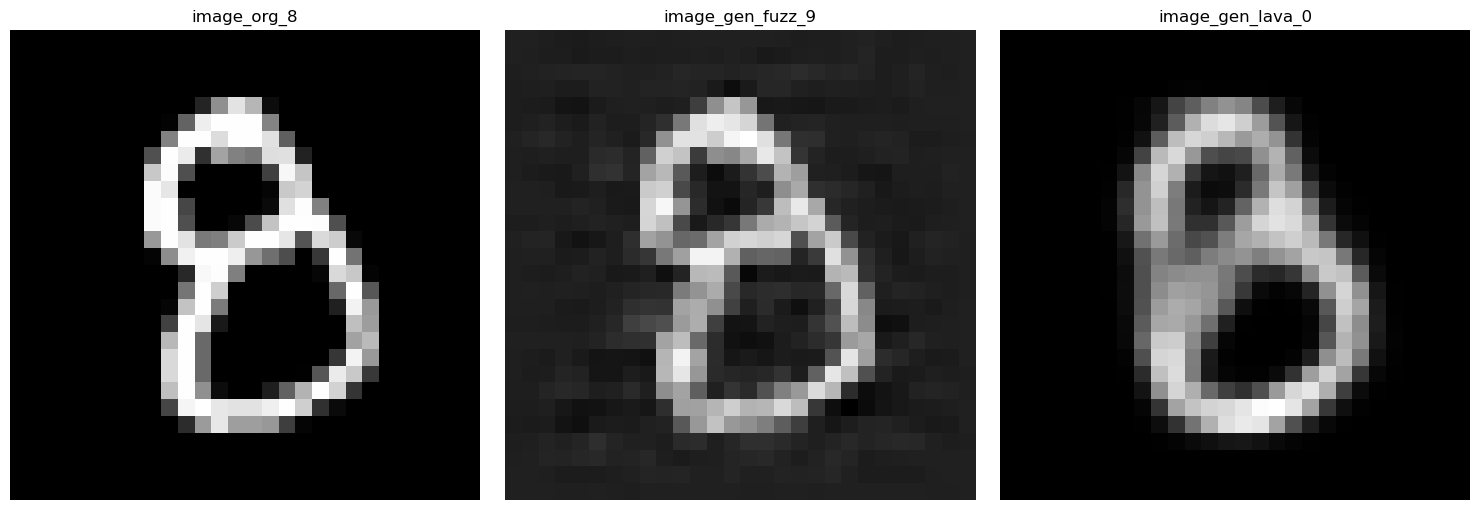

1/1 [==============================] - 0s 21ms/step


 12%|█████▎                                    | 25/200 [06:26<34:35, 11.86s/it]

d_fuzz: 0.10771079361438751
d_lava: 1.400461196899414
kl_fuzz: 0.9106029272079468
kl_lava: inf
ws_fuzz: 0.001494699462594382
ws_lava: 0.0005163110001578394
js_fuzz: 0.4997204840183258
js_lava: inf
ce_fuzz: 0.9106029868125916
ce_lava: inf
mse_fuzz: 4.625761448551202e-06
mse_lava: 1.8895267430707463e-06
1/1 [==============================] - 0s 22ms/step


 13%|█████▍                                    | 26/200 [06:42<37:51, 13.05s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█████▋                                    | 27/200 [06:58<40:07, 13.91s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█████▉                                    | 28/200 [07:13<41:30, 14.48s/it]

1/1 [==============================] - 0s 21ms/step


 14%|██████                                    | 29/200 [07:29<42:34, 14.94s/it]

1/1 [==============================] - 0s 22ms/step


 15%|██████▎                                   | 30/200 [07:45<43:05, 15.21s/it]

1/1 [==============================] - 0s 22ms/step


 16%|██████▌                                   | 31/200 [08:01<43:17, 15.37s/it]

1/1 [==============================] - 0s 22ms/step


 16%|██████▋                                   | 32/200 [08:17<43:22, 15.49s/it]

1/1 [==============================] - 0s 22ms/step


 16%|██████▉                                   | 33/200 [08:33<43:53, 15.77s/it]

1/1 [==============================] - 0s 22ms/step


 17%|███████▏                                  | 34/200 [08:49<43:35, 15.76s/it]

1/1 [==============================] - 0s 76ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


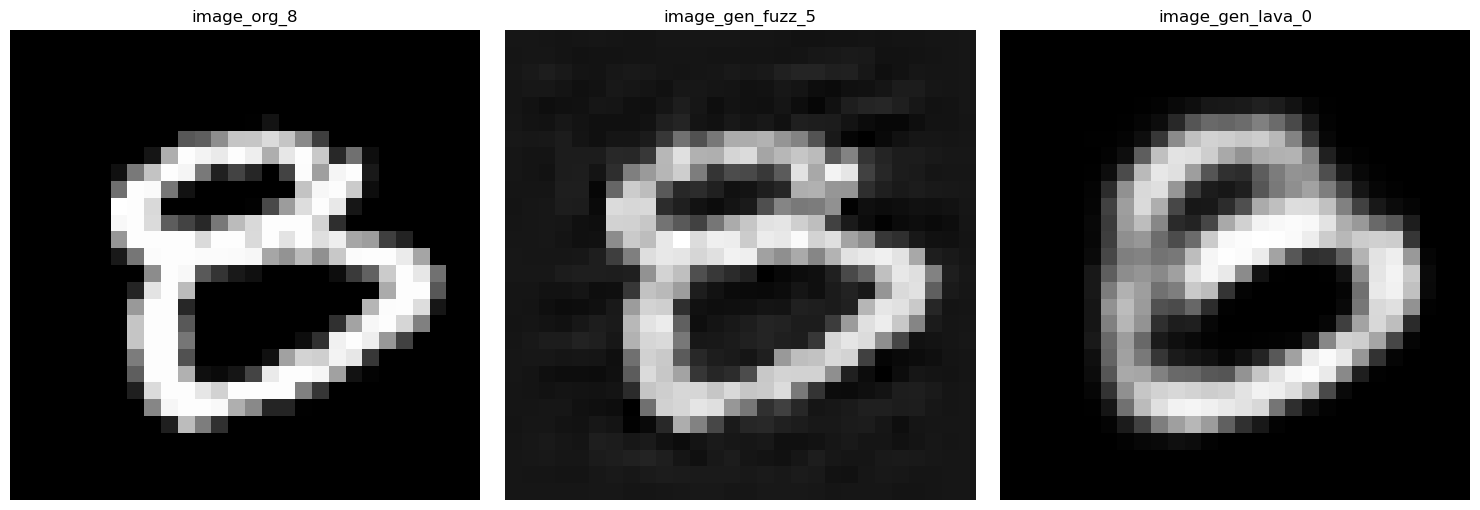

1/1 [==============================] - 0s 21ms/step


 18%|███████▎                                  | 35/200 [08:52<32:50, 11.94s/it]

d_fuzz: 0.0712551400065422
d_lava: 1.8734958171844482
kl_fuzz: 0.5248426198959351
kl_lava: inf
ws_fuzz: 0.0010324051070581066
ws_lava: 0.0003528849562266912
js_fuzz: 0.2842912971973419
js_lava: inf
ce_fuzz: 0.5248426198959351
ce_lava: inf
mse_fuzz: 1.7805438119466999e-06
mse_lava: 1.8753451058728388e-06
1/1 [==============================] - 0s 22ms/step


 18%|███████▌                                  | 36/200 [09:08<35:52, 13.12s/it]

1/1 [==============================] - 0s 22ms/step


 18%|███████▊                                  | 37/200 [09:24<37:50, 13.93s/it]

1/1 [==============================] - 0s 22ms/step


 19%|███████▉                                  | 38/200 [09:39<39:07, 14.49s/it]

1/1 [==============================] - 0s 22ms/step


 20%|████████▏                                 | 39/200 [09:55<39:49, 14.84s/it]

1/1 [==============================] - 0s 21ms/step


 20%|████████▍                                 | 40/200 [10:11<40:29, 15.18s/it]

1/1 [==============================] - 0s 21ms/step


 20%|████████▌                                 | 41/200 [10:27<40:38, 15.33s/it]

1/1 [==============================] - 0s 22ms/step


 21%|████████▊                                 | 42/200 [10:43<40:47, 15.49s/it]

1/1 [==============================] - 0s 22ms/step


 22%|█████████                                 | 43/200 [10:59<40:52, 15.62s/it]

1/1 [==============================] - 0s 23ms/step


 22%|█████████▏                                | 44/200 [11:14<40:53, 15.73s/it]

1/1 [==============================] - 0s 22ms/step


 22%|█████████▍                                | 45/200 [11:30<40:42, 15.76s/it]

1/1 [==============================] - 0s 23ms/step


 23%|█████████▋                                | 46/200 [11:47<40:49, 15.90s/it]

1/1 [==============================] - 0s 22ms/step


 24%|█████████▊                                | 47/200 [12:02<40:34, 15.91s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██████████                                | 48/200 [12:18<40:22, 15.94s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██████████▎                               | 49/200 [12:34<40:04, 15.92s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██████████▌                               | 50/200 [12:51<39:58, 15.99s/it]

1/1 [==============================] - 0s 22ms/step


 26%|██████████▋                               | 51/200 [13:06<39:34, 15.94s/it]

1/1 [==============================] - 0s 23ms/step


 26%|██████████▉                               | 52/200 [13:22<39:07, 15.86s/it]

1/1 [==============================] - 0s 22ms/step


 26%|███████████▏                              | 53/200 [13:38<39:13, 16.01s/it]

1/1 [==============================] - 0s 22ms/step


 27%|███████████▎                              | 54/200 [13:54<38:49, 15.96s/it]

1/1 [==============================] - 0s 22ms/step


 28%|███████████▌                              | 55/200 [14:10<38:24, 15.89s/it]

1/1 [==============================] - 0s 24ms/step


 28%|███████████▊                              | 56/200 [14:26<38:01, 15.84s/it]

1/1 [==============================] - 0s 22ms/step


 28%|███████████▉                              | 57/200 [14:42<38:08, 16.01s/it]

1/1 [==============================] - 0s 21ms/step


 29%|████████████▏                             | 58/200 [14:58<37:44, 15.95s/it]

1/1 [==============================] - 0s 21ms/step


 30%|████████████▍                             | 59/200 [15:13<37:14, 15.85s/it]

1/1 [==============================] - 0s 22ms/step


 30%|████████████▌                             | 60/200 [15:29<36:54, 15.82s/it]

1/1 [==============================] - 0s 23ms/step
Misclassification achieved at iteration 40
1/1 [==============================] - 0s 21ms/step


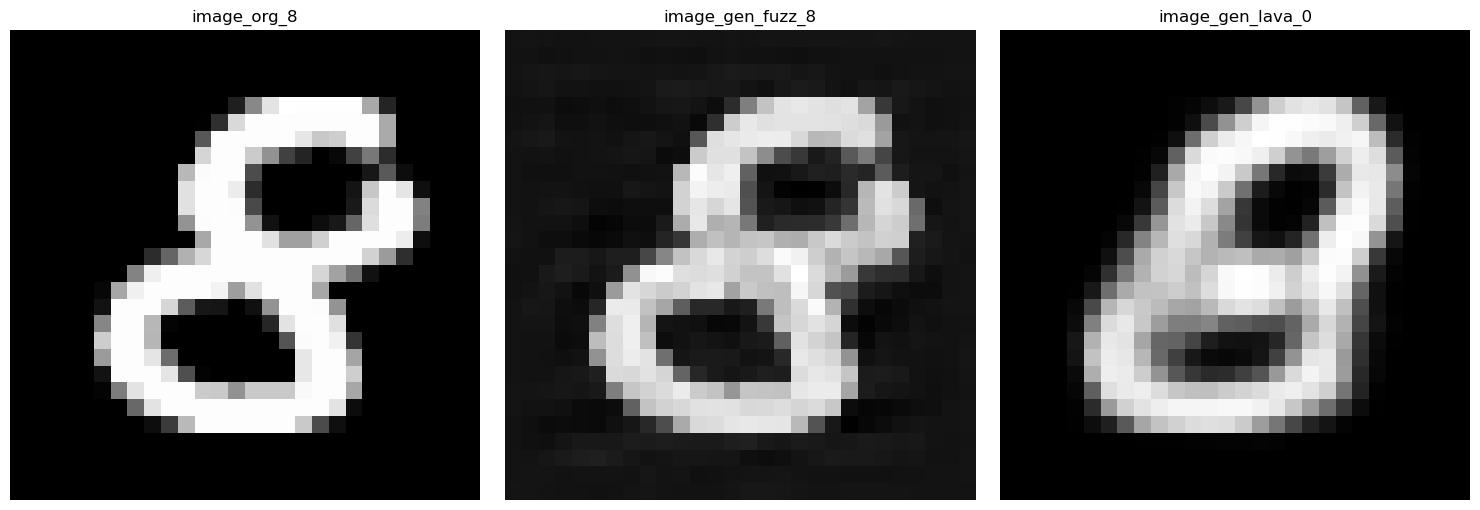

1/1 [==============================] - 0s 22ms/step


 30%|████████████▊                             | 61/200 [15:38<31:45, 13.71s/it]

d_fuzz: 0.11059454828500748
d_lava: 1.6784636974334717
kl_fuzz: 0.3880248963832855
kl_lava: inf
ws_fuzz: 0.0008220977107454501
ws_lava: 0.0003315467334068754
js_fuzz: 0.2077023684978485
js_lava: inf
ce_fuzz: 0.3880247473716736
ce_lava: inf
mse_fuzz: 9.87280031949922e-07
mse_lava: 1.2434426253093989e-06
1/1 [==============================] - 0s 22ms/step


 31%|█████████████                             | 62/200 [15:54<32:56, 14.32s/it]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████▏                            | 63/200 [16:10<33:44, 14.78s/it]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████▍                            | 64/200 [16:26<34:26, 15.19s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 13
1/1 [==============================] - 0s 23ms/step


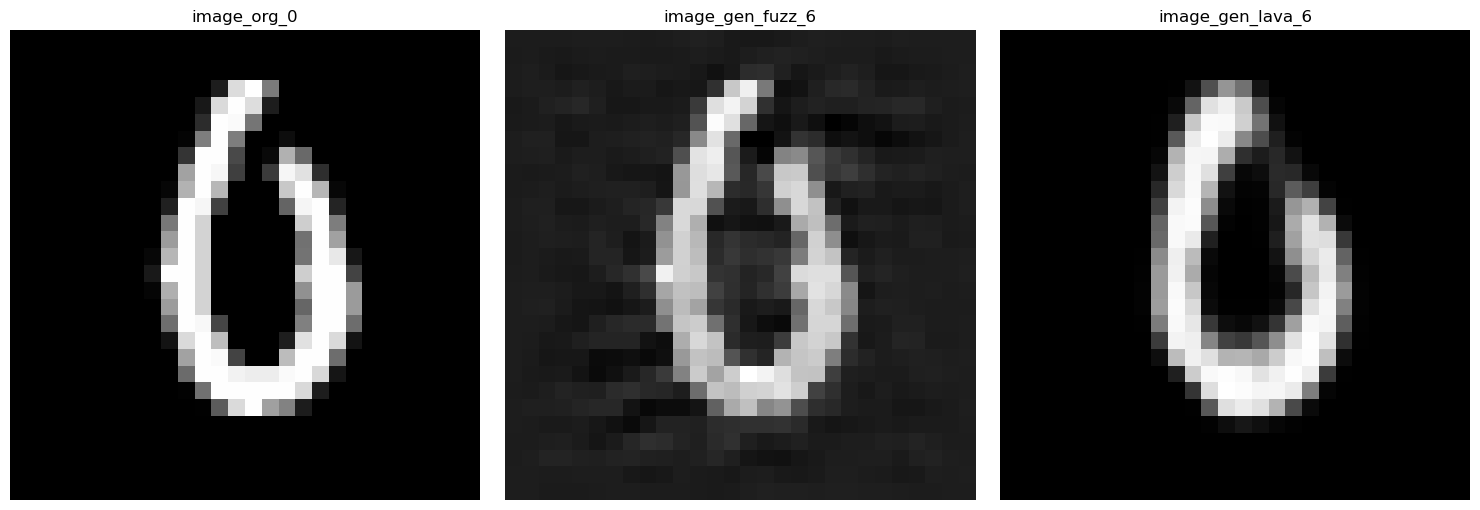

1/1 [==============================] - 0s 22ms/step


 32%|█████████████▋                            | 65/200 [16:30<27:06, 12.05s/it]

d_fuzz: 0.1097884252667427
d_lava: 1.4493021965026855
kl_fuzz: 0.9074193835258484
kl_lava: inf
ws_fuzz: 0.0015018091041792087
ws_lava: 0.0001672615666672457
js_fuzz: 0.4829655587673187
js_lava: inf
ce_fuzz: 0.9074193239212036
ce_lava: inf
mse_fuzz: 4.965442713000812e-06
mse_lava: 1.3728650856137392e-06
1/1 [==============================] - 0s 23ms/step


 33%|█████████████▊                            | 66/200 [16:50<31:42, 14.20s/it]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████                            | 67/200 [17:06<32:41, 14.75s/it]

1/1 [==============================] - 0s 22ms/step


 34%|██████████████▎                           | 68/200 [17:22<33:22, 15.17s/it]

1/1 [==============================] - 0s 22ms/step


 34%|██████████████▍                           | 69/200 [17:38<33:59, 15.57s/it]

1/1 [==============================] - 0s 22ms/step


 35%|██████████████▋                           | 70/200 [17:54<34:05, 15.73s/it]

1/1 [==============================] - 0s 23ms/step


 36%|██████████████▉                           | 71/200 [18:11<34:01, 15.83s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████                           | 72/200 [18:27<34:04, 15.97s/it]

1/1 [==============================] - 0s 22ms/step


 36%|███████████████▎                          | 73/200 [18:43<33:56, 16.04s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███████████████▌                          | 74/200 [18:59<33:38, 16.02s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███████████████▊                          | 75/200 [19:15<33:19, 16.00s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███████████████▉                          | 76/200 [19:31<33:07, 16.03s/it]

1/1 [==============================] - 0s 22ms/step


 38%|████████████████▏                         | 77/200 [19:47<32:51, 16.03s/it]

1/1 [==============================] - 0s 22ms/step


 39%|████████████████▍                         | 78/200 [20:03<32:35, 16.03s/it]

1/1 [==============================] - 0s 22ms/step


 40%|████████████████▌                         | 79/200 [20:19<32:17, 16.01s/it]

1/1 [==============================] - 0s 24ms/step


 40%|████████████████▊                         | 80/200 [20:36<32:16, 16.14s/it]

1/1 [==============================] - 0s 35ms/step


 40%|█████████████████                         | 81/200 [20:52<31:56, 16.10s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 66
1/1 [==============================] - 0s 22ms/step


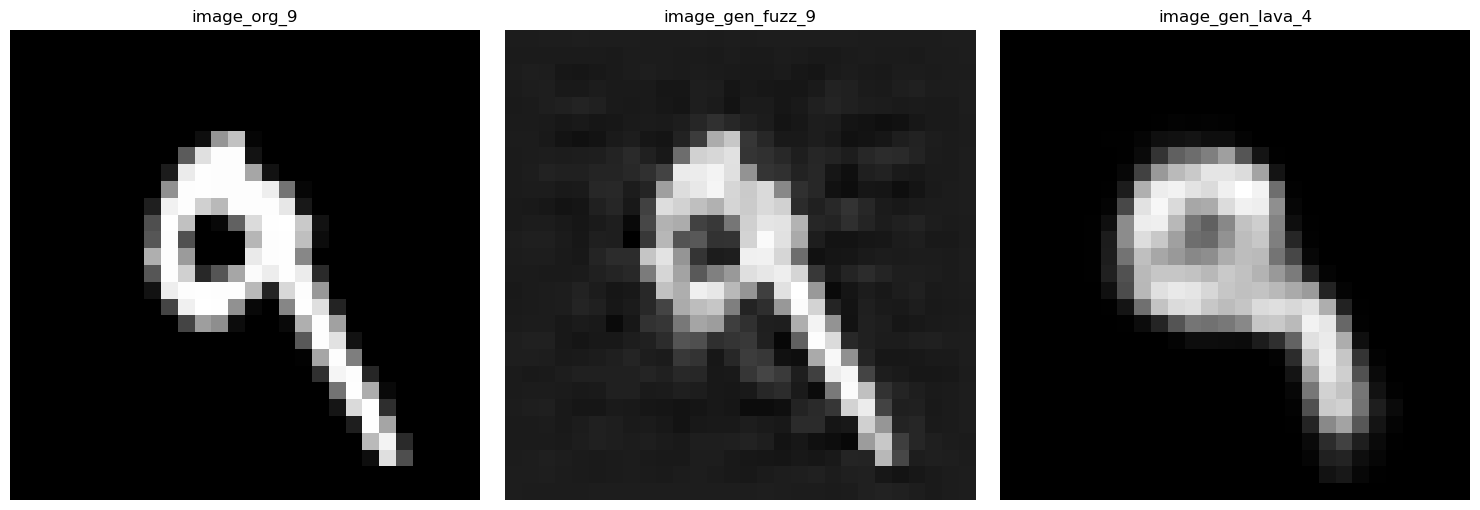

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████▏                        | 82/200 [21:04<29:14, 14.87s/it]

d_fuzz: 0.13810482621192932
d_lava: 1.8732632398605347
kl_fuzz: 0.980250895023346
kl_lava: inf
ws_fuzz: 0.0015697069788706245
ws_lava: 0.00046111656806514686
js_fuzz: 0.5249654650688171
js_lava: inf
ce_fuzz: 0.980250895023346
ce_lava: inf
mse_fuzz: 6.112128176027909e-06
mse_lava: 3.872579327435233e-06
1/1 [==============================] - 0s 22ms/step


 42%|█████████████████▍                        | 83/200 [21:20<29:55, 15.35s/it]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████▋                        | 84/200 [21:36<30:16, 15.66s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 60
1/1 [==============================] - 0s 22ms/step


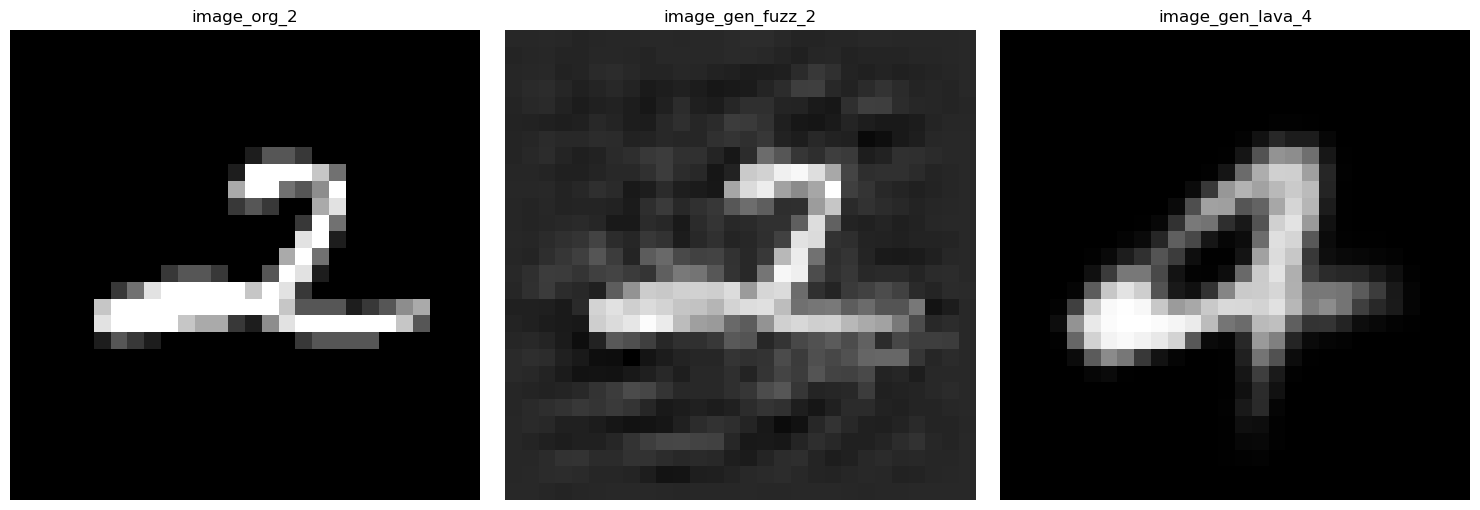

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████▊                        | 85/200 [21:48<27:24, 14.30s/it]

d_fuzz: 0.20734043419361115
d_lava: 1.3860816955566406
kl_fuzz: 1.365653157234192
kl_lava: inf
ws_fuzz: 0.0018589843089938194
ws_lava: 0.0005228053462613046
js_fuzz: 0.7085998058319092
js_lava: inf
ce_fuzz: 1.365653395652771
ce_lava: inf
mse_fuzz: 1.0321367881260812e-05
mse_lava: 7.718163942627143e-06
1/1 [==============================] - 0s 21ms/step
Misclassification achieved at iteration 25
1/1 [==============================] - 0s 23ms/step


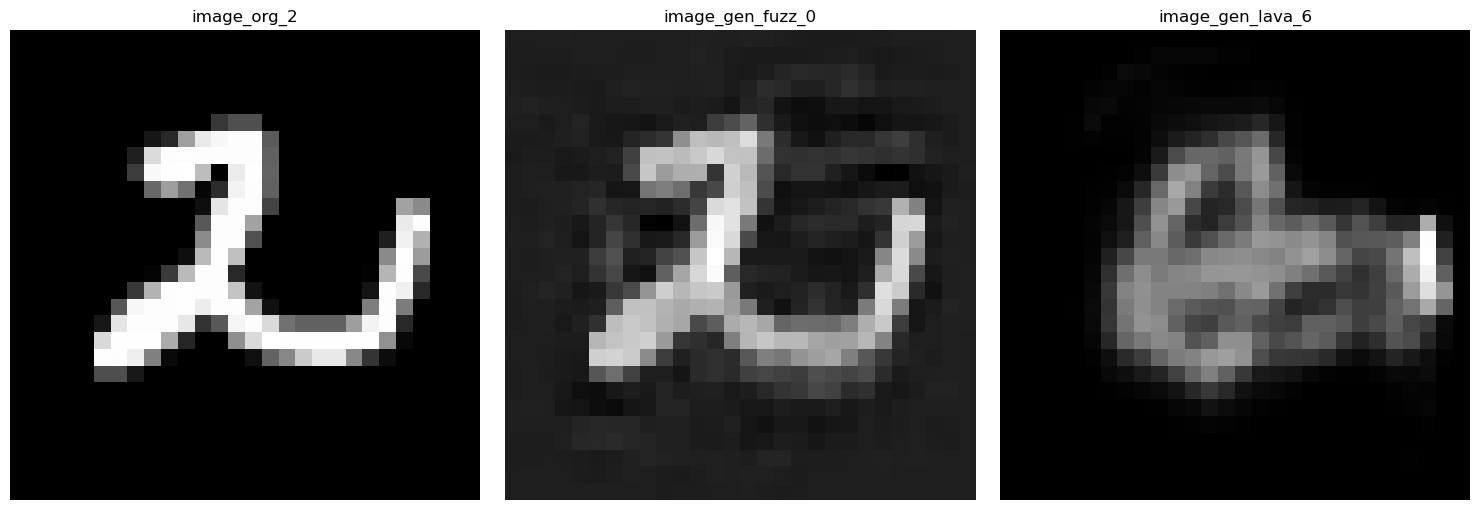

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████                        | 86/200 [21:54<22:39, 11.93s/it]

d_fuzz: 0.15371109545230865
d_lava: 1.159183382987976
kl_fuzz: 0.9124375581741333
kl_lava: inf
ws_fuzz: 0.0014993260595623057
ws_lava: 0.000784372488696445
js_fuzz: 0.49132445454597473
js_lava: inf
ce_fuzz: 0.9124374389648438
ce_lava: inf
mse_fuzz: 4.848933258472243e-06
mse_lava: 7.632199412910268e-06
1/1 [==============================] - 0s 72ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


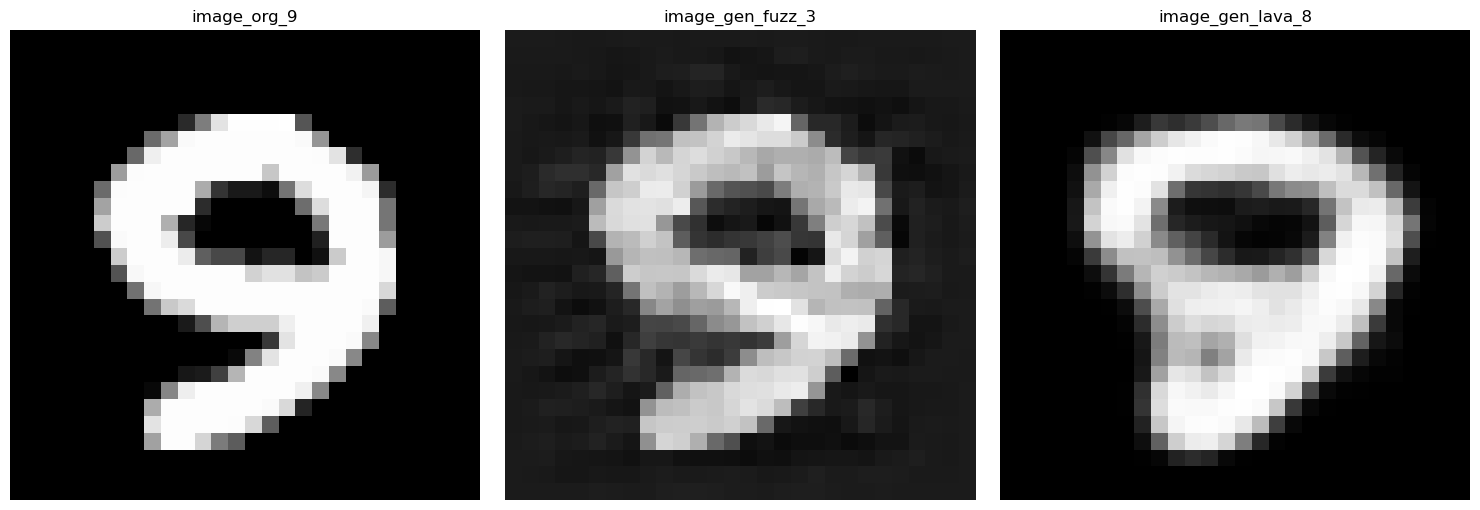

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████▎                       | 87/200 [21:57<17:26,  9.26s/it]

d_fuzz: 0.08662712574005127
d_lava: 1.7199474573135376
kl_fuzz: 0.477093905210495
kl_lava: inf
ws_fuzz: 0.0009609719015074636
ws_lava: 0.0002488618792411413
js_fuzz: 0.2551935315132141
js_lava: inf
ce_fuzz: 0.47709375619888306
ce_lava: inf
mse_fuzz: 1.2954468502357486e-06
mse_lava: 9.090407502299058e-07
1/1 [==============================] - 0s 21ms/step


 44%|██████████████████▍                       | 88/200 [22:13<21:00, 11.26s/it]

1/1 [==============================] - 0s 72ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


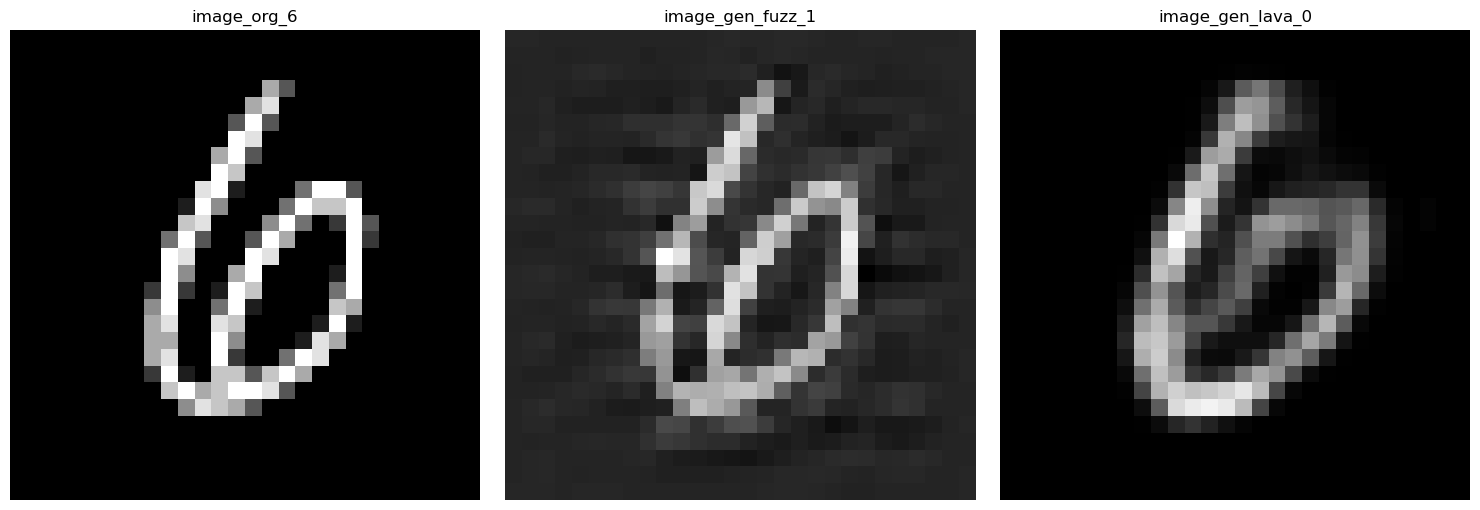

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████▋                       | 89/200 [22:16<16:15,  8.79s/it]

d_fuzz: 0.1382964849472046
d_lava: 1.324090600013733
kl_fuzz: 1.2097415924072266
kl_lava: inf
ws_fuzz: 0.001755987512482608
ws_lava: 0.0005817195605899017
js_fuzz: 0.6203681230545044
js_lava: inf
ce_fuzz: 1.2097413539886475
ce_lava: inf
mse_fuzz: 7.681734132347628e-06
mse_lava: 3.984405338997021e-06
1/1 [==============================] - 0s 22ms/step


 45%|██████████████████▉                       | 90/200 [22:32<20:15, 11.05s/it]

1/1 [==============================] - 0s 22ms/step


 46%|███████████████████                       | 91/200 [22:48<22:41, 12.49s/it]

1/1 [==============================] - 0s 21ms/step


 46%|███████████████████▎                      | 92/200 [23:04<24:13, 13.46s/it]

1/1 [==============================] - 0s 22ms/step


 46%|███████████████████▌                      | 93/200 [23:20<25:12, 14.14s/it]

1/1 [==============================] - 0s 22ms/step


 47%|███████████████████▋                      | 94/200 [23:36<26:03, 14.75s/it]

1/1 [==============================] - 0s 21ms/step
Misclassification achieved at iteration 88
1/1 [==============================] - 0s 24ms/step


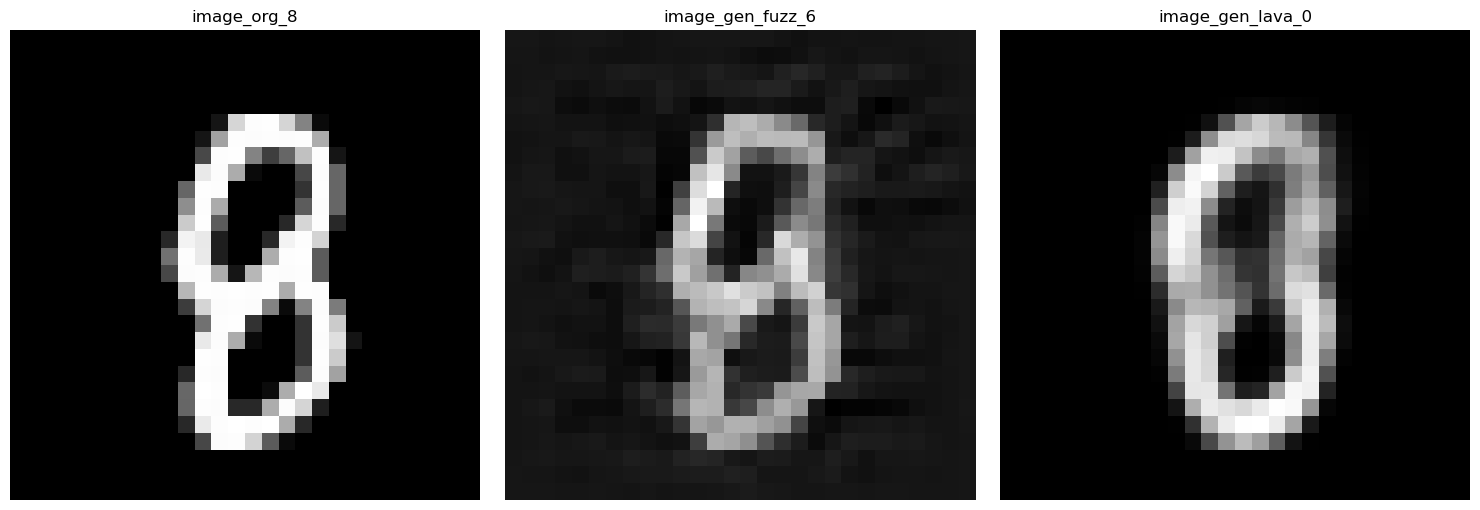

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████▉                      | 95/200 [23:50<25:44, 14.71s/it]

d_fuzz: 0.20645056664943695
d_lava: 1.3901935815811157
kl_fuzz: 0.7657405138015747
kl_lava: inf
ws_fuzz: 0.001327277712446129
ws_lava: 0.0003459002008629195
js_fuzz: 0.4085026681423187
js_lava: inf
ce_fuzz: 0.7657406330108643
ce_lava: inf
mse_fuzz: 3.856698640447576e-06
mse_lava: 2.0389943529153243e-06
1/1 [==============================] - 0s 23ms/step


 48%|████████████████████▏                     | 96/200 [24:06<25:58, 14.98s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████████████████████▎                     | 97/200 [24:22<26:11, 15.25s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 97
1/1 [==============================] - 0s 22ms/step


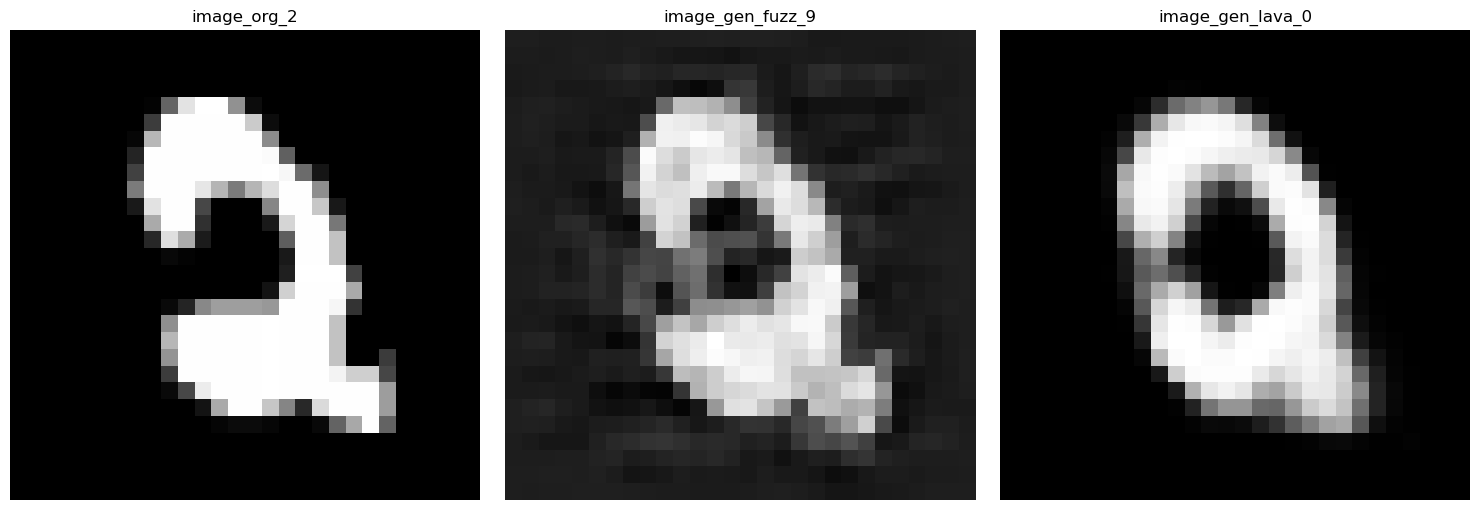

1/1 [==============================] - 0s 23ms/step


 49%|████████████████████▌                     | 98/200 [24:39<26:45, 15.74s/it]

d_fuzz: 0.17500944435596466
d_lava: 1.638219952583313
kl_fuzz: 0.6496059894561768
kl_lava: inf
ws_fuzz: 0.0012038007252511084
ws_lava: 0.0001950991158901378
js_fuzz: 0.3543773293495178
js_lava: inf
ce_fuzz: 0.6496060490608215
ce_lava: inf
mse_fuzz: 2.4151286197593436e-06
mse_lava: 8.701495062268805e-07
1/1 [==============================] - 0s 23ms/step


 50%|████████████████████▊                     | 99/200 [24:55<26:39, 15.84s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▌                    | 100/200 [25:11<26:22, 15.82s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▋                    | 101/200 [25:26<26:09, 15.86s/it]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████▉                    | 102/200 [25:43<26:05, 15.97s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████                    | 103/200 [25:59<25:47, 15.95s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▎                   | 104/200 [26:14<25:27, 15.91s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▌                   | 105/200 [26:30<25:07, 15.87s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████████████████████▋                   | 106/200 [26:46<25:00, 15.96s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████████████████████▉                   | 107/200 [27:02<24:42, 15.94s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 56
1/1 [==============================] - 0s 22ms/step


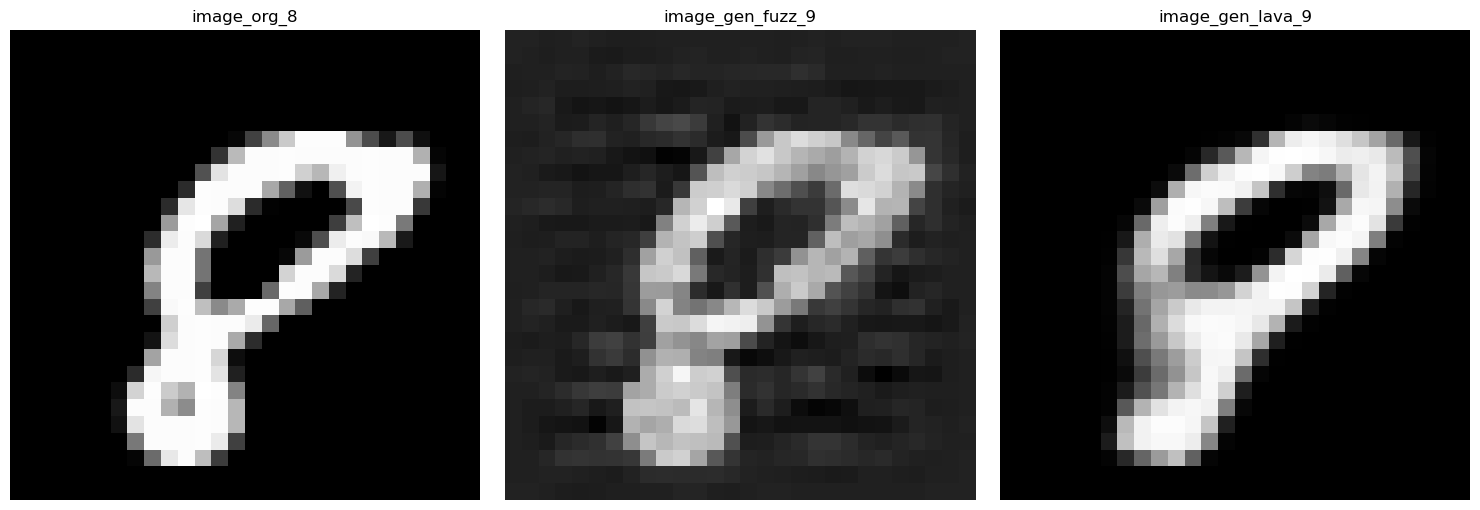

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████▏                  | 108/200 [27:13<21:53, 14.27s/it]

d_fuzz: 0.14382150769233704
d_lava: 1.5399144887924194
kl_fuzz: 0.7620686888694763
kl_lava: inf
ws_fuzz: 0.0013323676931966994
ws_lava: 0.0001415539371590646
js_fuzz: 0.41776755452156067
js_lava: inf
ce_fuzz: 0.7620685696601868
ce_lava: inf
mse_fuzz: 3.1108145321923075e-06
mse_lava: 1.2682837677857606e-06
1/1 [==============================] - 0s 21ms/step


 55%|██████████████████████▎                  | 109/200 [27:28<22:19, 14.72s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 84
1/1 [==============================] - 0s 22ms/step


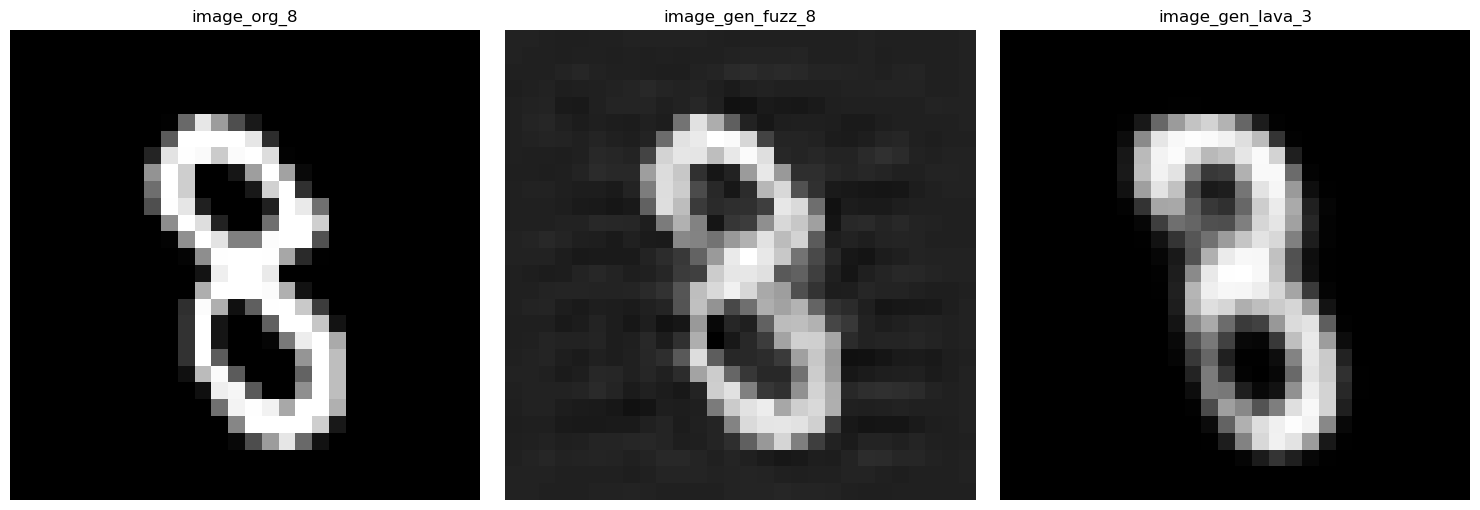

1/1 [==============================] - 0s 21ms/step


 55%|██████████████████████▌                  | 110/200 [27:43<21:58, 14.65s/it]

d_fuzz: 0.15864358842372894
d_lava: 1.3303297758102417
kl_fuzz: 0.9614498019218445
kl_lava: inf
ws_fuzz: 0.0015429409695663743
ws_lava: 0.0002982108576531375
js_fuzz: 0.5289583206176758
js_lava: inf
ce_fuzz: 0.9614496827125549
ce_lava: inf
mse_fuzz: 5.237405275693163e-06
mse_lava: 2.1449786800076254e-06
1/1 [==============================] - 0s 22ms/step


 56%|██████████████████████▊                  | 111/200 [27:59<22:24, 15.11s/it]

1/1 [==============================] - 0s 21ms/step


 56%|██████████████████████▉                  | 112/200 [28:15<22:25, 15.29s/it]

1/1 [==============================] - 0s 22ms/step


 56%|███████████████████████▏                 | 113/200 [28:31<22:25, 15.46s/it]

1/1 [==============================] - 0s 21ms/step


 57%|███████████████████████▎                 | 114/200 [28:47<22:21, 15.60s/it]

1/1 [==============================] - 0s 22ms/step


 57%|███████████████████████▌                 | 115/200 [29:03<22:24, 15.81s/it]

1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████▊                 | 116/200 [29:19<22:11, 15.85s/it]

1/1 [==============================] - 0s 22ms/step


 58%|███████████████████████▉                 | 117/200 [29:35<21:57, 15.88s/it]

1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████▏                | 118/200 [29:51<21:45, 15.92s/it]

1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████▍                | 119/200 [30:07<21:31, 15.95s/it]

1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████▌                | 120/200 [30:23<21:23, 16.04s/it]

1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████▊                | 121/200 [30:39<21:05, 16.02s/it]

1/1 [==============================] - 0s 21ms/step


 61%|█████████████████████████                | 122/200 [30:55<20:46, 15.98s/it]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████▏               | 123/200 [31:11<20:28, 15.95s/it]

1/1 [==============================] - 0s 72ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


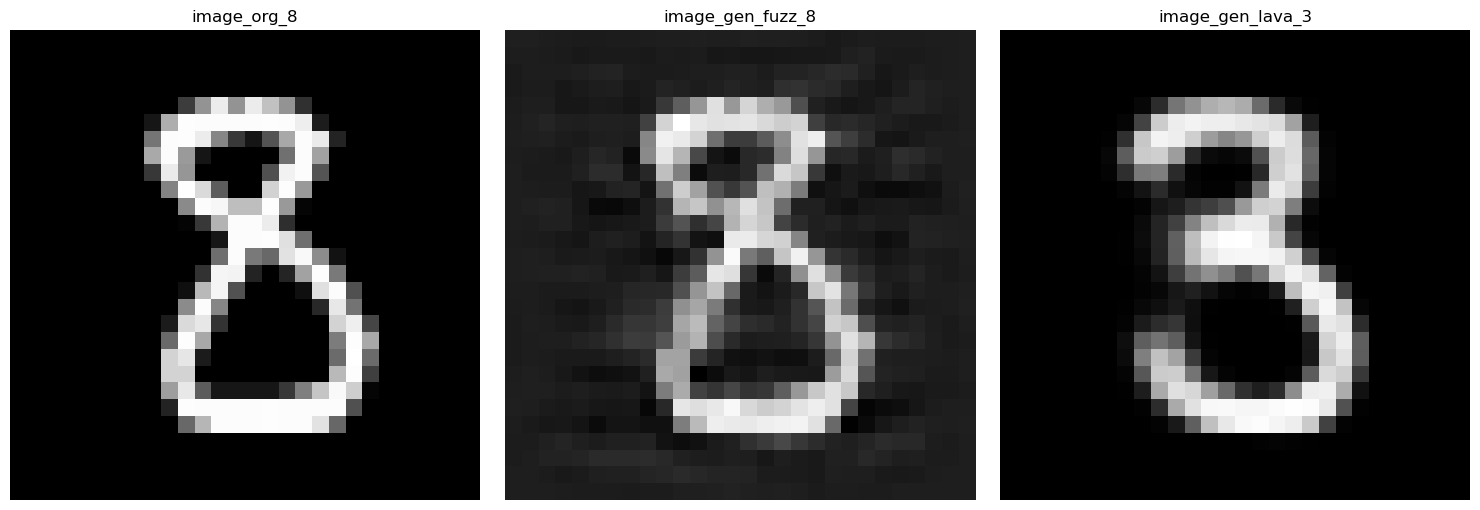

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████▍               | 124/200 [31:14<15:18, 12.09s/it]

d_fuzz: 0.15771710872650146
d_lava: 1.6412118673324585
kl_fuzz: 0.8387595415115356
kl_lava: inf
ws_fuzz: 0.0014202738262165625
ws_lava: 0.00015951257328752355
js_fuzz: 0.44961240887641907
js_lava: inf
ce_fuzz: 0.8387595415115356
ce_lava: inf
mse_fuzz: 4.079738118889509e-06
mse_lava: 2.2644003365712706e-06
1/1 [==============================] - 0s 72ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


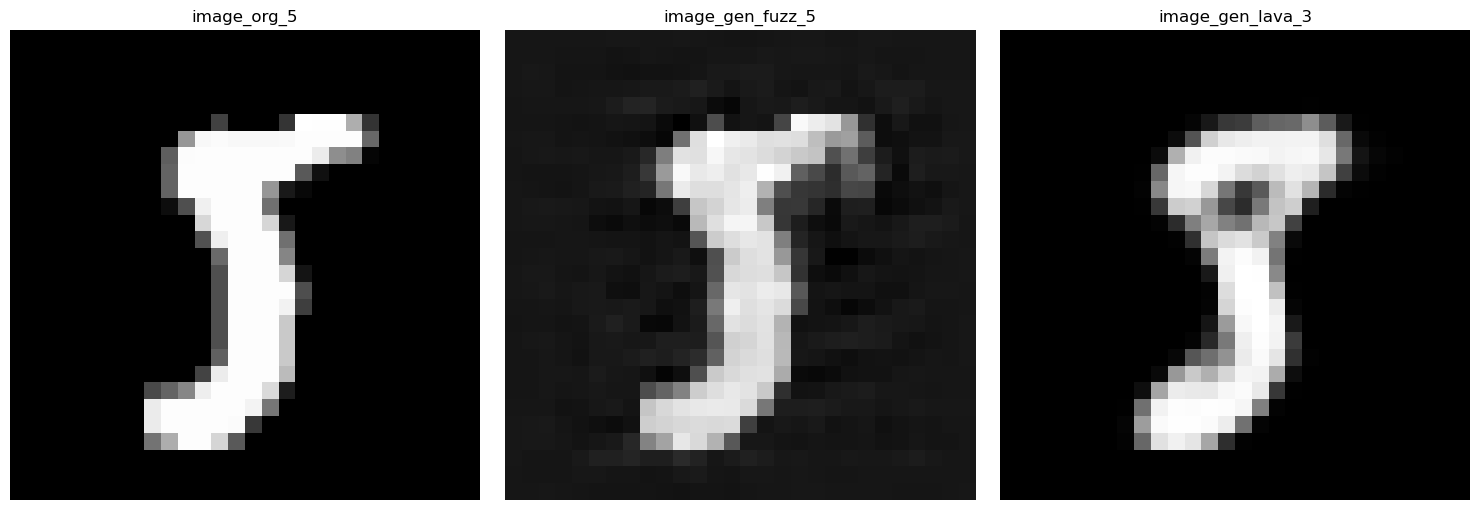

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████▋               | 125/200 [31:17<11:42,  9.37s/it]

d_fuzz: 0.07839633524417877
d_lava: 1.139714002609253
kl_fuzz: 0.6873367428779602
kl_lava: inf
ws_fuzz: 0.0012551557892576818
ws_lava: 0.00012216488690951967
js_fuzz: 0.35668158531188965
js_lava: inf
ce_fuzz: 0.6873370409011841
ce_lava: inf
mse_fuzz: 3.1687618502473924e-06
mse_lava: 1.5621055808878737e-06
1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████▊               | 126/200 [31:33<14:07, 11.45s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████████████████████████               | 127/200 [31:49<15:33, 12.79s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████████████████████████▏              | 128/200 [32:05<16:25, 13.68s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 9
1/1 [==============================] - 0s 22ms/step


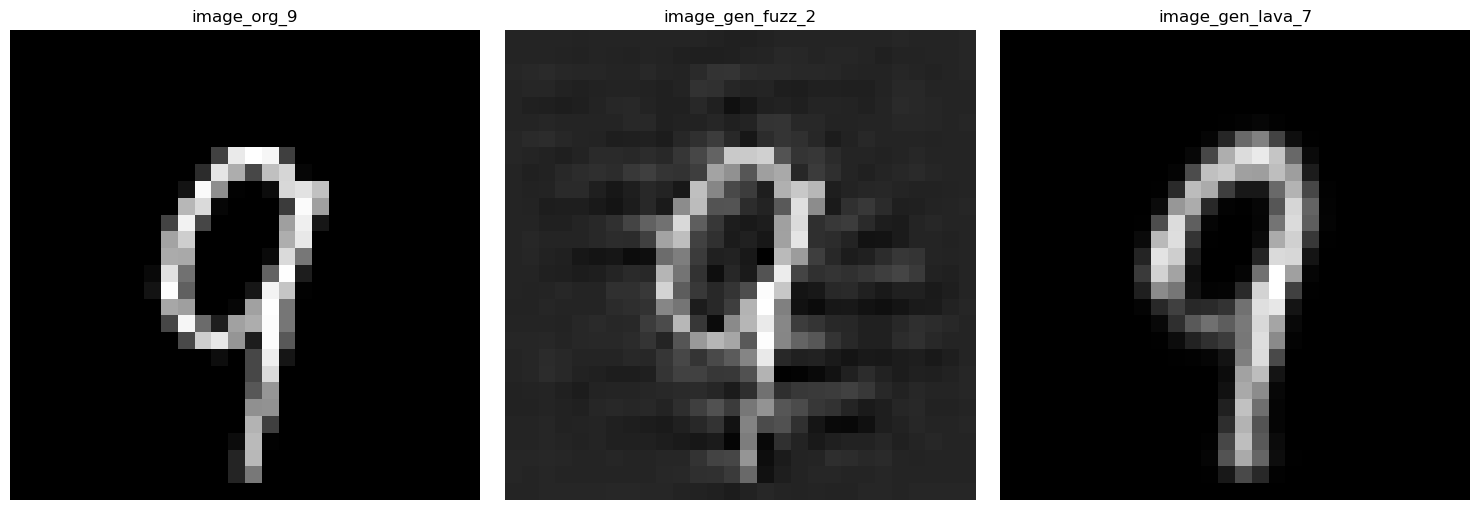

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████▍              | 129/200 [32:09<12:49, 10.84s/it]

d_fuzz: 0.2313050478696823
d_lava: 1.0293734073638916
kl_fuzz: 1.53182852268219
kl_lava: inf
ws_fuzz: 0.0019564923226685744
ws_lava: 0.0003538973383213762
js_fuzz: 0.8320078253746033
js_lava: inf
ce_fuzz: 1.53182852268219
ce_lava: inf
mse_fuzz: 1.3172413673601113e-05
mse_lava: 3.8322627915476914e-06
1/1 [==============================] - 0s 21ms/step


 65%|██████████████████████████▋              | 130/200 [32:25<14:22, 12.32s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████▊              | 131/200 [32:41<15:38, 13.59s/it]

1/1 [==============================] - 0s 22ms/step


 66%|███████████████████████████              | 132/200 [32:57<16:12, 14.30s/it]

1/1 [==============================] - 0s 23ms/step


 66%|███████████████████████████▎             | 133/200 [33:13<16:32, 14.81s/it]

1/1 [==============================] - 0s 22ms/step


 67%|███████████████████████████▍             | 134/200 [33:29<16:38, 15.13s/it]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████▋             | 135/200 [33:45<16:37, 15.35s/it]

1/1 [==============================] - 0s 23ms/step


 68%|███████████████████████████▉             | 136/200 [34:02<16:41, 15.65s/it]

1/1 [==============================] - 0s 22ms/step


 68%|████████████████████████████             | 137/200 [34:18<16:34, 15.78s/it]

1/1 [==============================] - 0s 22ms/step


 69%|████████████████████████████▎            | 138/200 [34:34<16:23, 15.86s/it]

1/1 [==============================] - 0s 72ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


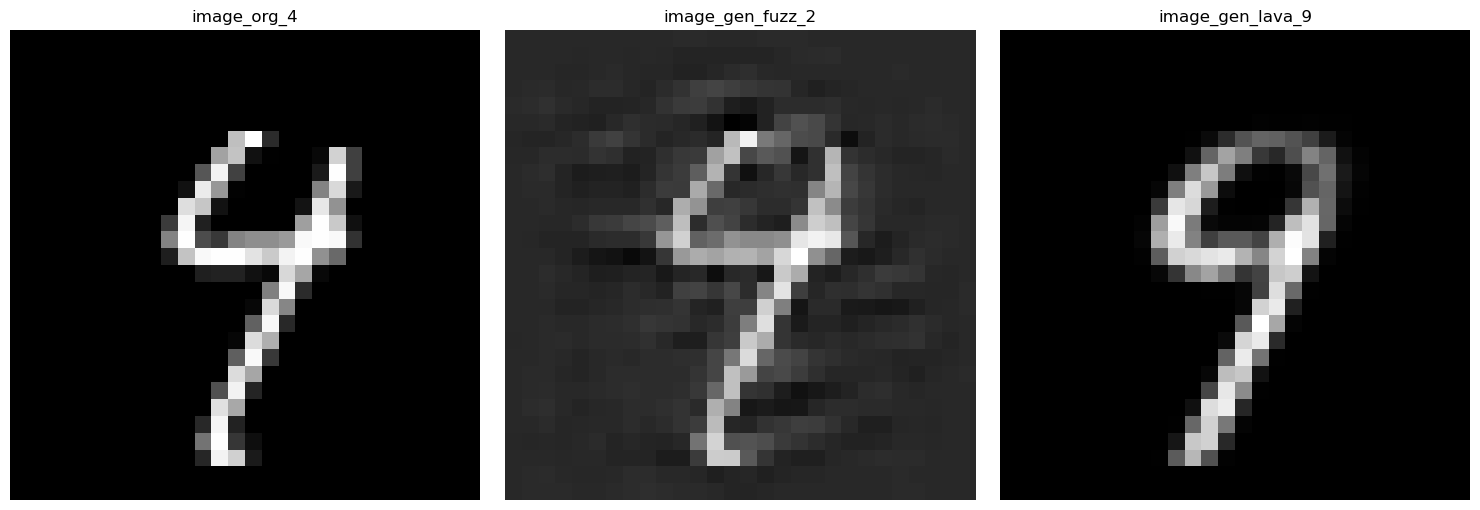

1/1 [==============================] - 0s 22ms/step


 70%|████████████████████████████▍            | 139/200 [34:37<12:13, 12.02s/it]

d_fuzz: 0.32638606429100037
d_lava: 1.2392951250076294
kl_fuzz: 1.523305892944336
kl_lava: inf
ws_fuzz: 0.0019441118161290542
ws_lava: 0.0003063743602900836
js_fuzz: 0.8383415341377258
js_lava: inf
ce_fuzz: 1.5233056545257568
ce_lava: inf
mse_fuzz: 1.2967265320185106e-05
mse_lava: 3.861727691401029e-06
1/1 [==============================] - 0s 23ms/step


 70%|████████████████████████████▋            | 140/200 [34:53<13:23, 13.39s/it]

1/1 [==============================] - 0s 22ms/step


 70%|████████████████████████████▉            | 141/200 [35:09<13:53, 14.12s/it]

1/1 [==============================] - 0s 23ms/step


 71%|█████████████████████████████            | 142/200 [35:26<14:22, 14.87s/it]

1/1 [==============================] - 0s 22ms/step


 72%|█████████████████████████████▎           | 143/200 [35:42<14:32, 15.30s/it]

1/1 [==============================] - 0s 22ms/step


 72%|█████████████████████████████▌           | 144/200 [36:01<15:21, 16.46s/it]

1/1 [==============================] - 0s 22ms/step


 72%|█████████████████████████████▋           | 145/200 [36:18<15:12, 16.58s/it]

1/1 [==============================] - 0s 23ms/step


 73%|█████████████████████████████▉           | 146/200 [36:34<14:46, 16.42s/it]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████▏          | 147/200 [36:51<14:33, 16.49s/it]

1/1 [==============================] - 0s 29ms/step


 74%|██████████████████████████████▎          | 148/200 [37:07<14:13, 16.41s/it]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████▌          | 149/200 [37:23<13:52, 16.32s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 2
1/1 [==============================] - 0s 22ms/step


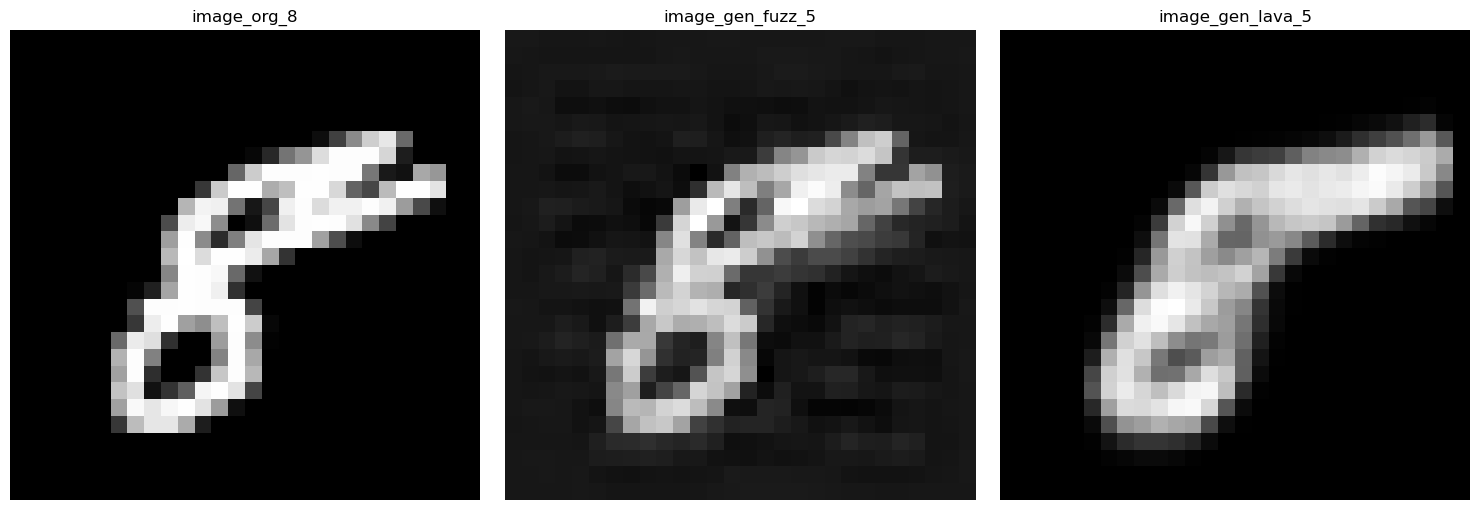

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████▊          | 150/200 [37:26<10:20, 12.42s/it]

d_fuzz: 0.21158112585544586
d_lava: 1.0749696493148804
kl_fuzz: 0.6940624713897705
kl_lava: inf
ws_fuzz: 0.0012522549698736167
ws_lava: 0.00039970393992376605
js_fuzz: 0.37028414011001587
js_lava: inf
ce_fuzz: 0.6940624713897705
ce_lava: inf
mse_fuzz: 3.0882454211678123e-06
mse_lava: 2.000491804210469e-06
1/1 [==============================] - 0s 22ms/step


 76%|██████████████████████████████▉          | 151/200 [37:43<11:03, 13.54s/it]

1/1 [==============================] - 0s 73ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


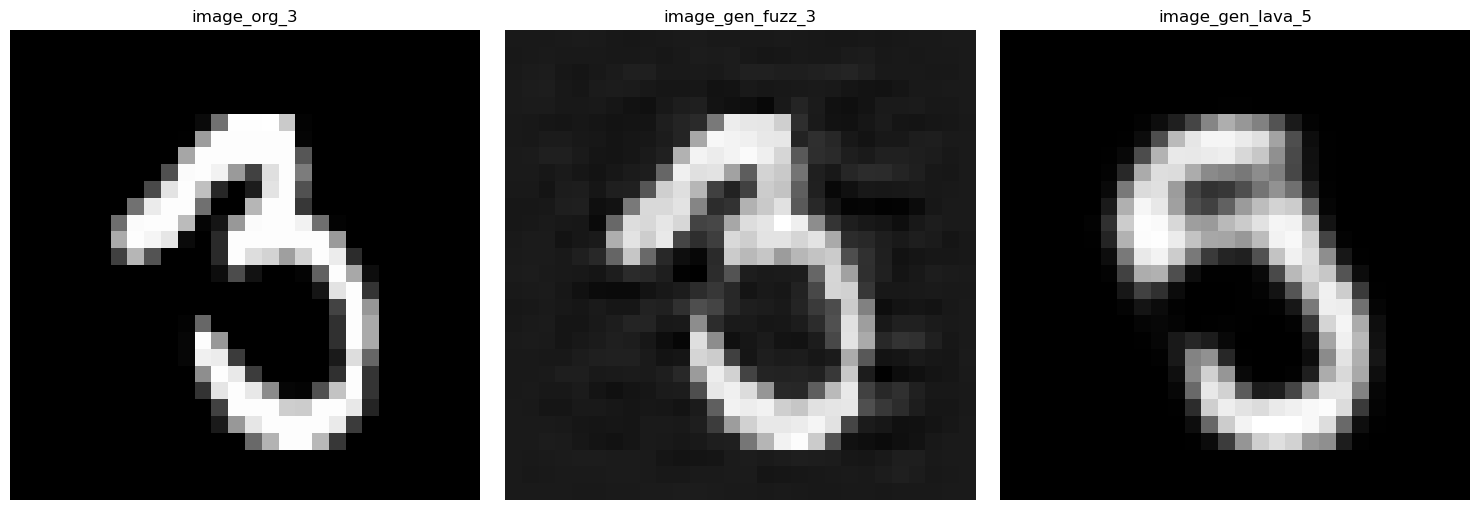

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████▏         | 152/200 [37:46<08:19, 10.40s/it]

d_fuzz: 0.09423879534006119
d_lava: 1.763017177581787
kl_fuzz: 0.7456732988357544
kl_lava: inf
ws_fuzz: 0.0013238254453992748
ws_lava: 0.0003544459108194657
js_fuzz: 0.4086727201938629
js_lava: inf
ce_fuzz: 0.7456732392311096
ce_lava: inf
mse_fuzz: 3.5951295558334095e-06
mse_lava: 2.406449993941351e-06
1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████▎         | 153/200 [38:02<09:32, 12.19s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████▌         | 154/200 [38:18<10:14, 13.37s/it]

1/1 [==============================] - 0s 22ms/step


 78%|███████████████████████████████▊         | 155/200 [38:34<10:36, 14.15s/it]

1/1 [==============================] - 0s 75ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


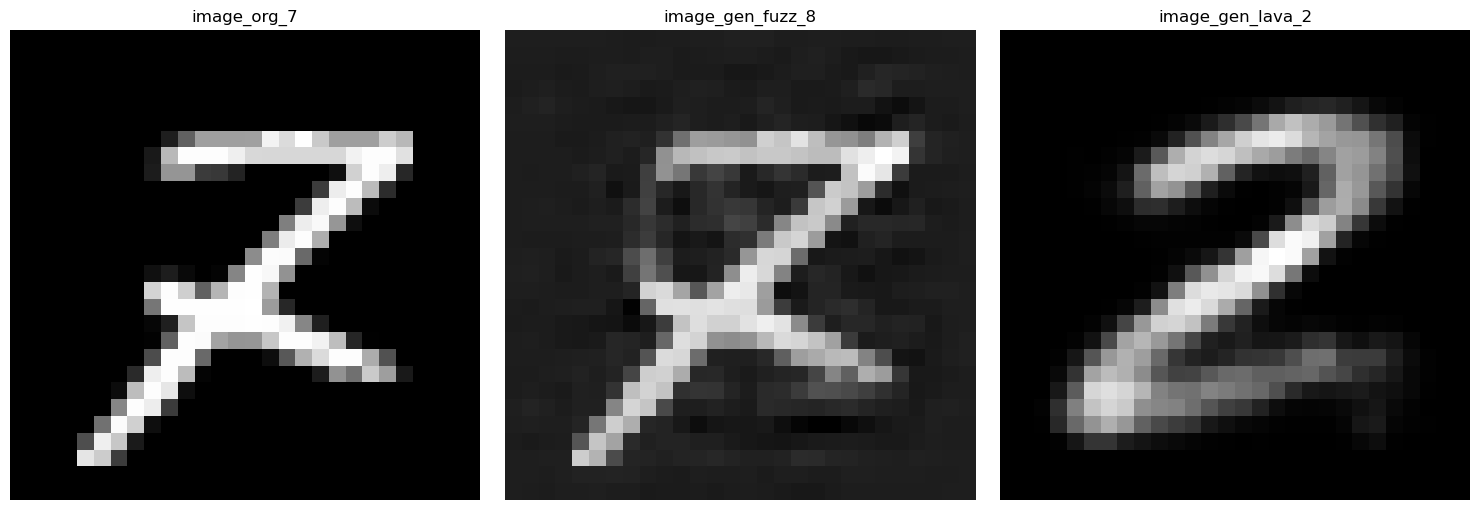

1/1 [==============================] - 0s 21ms/step


 78%|███████████████████████████████▉         | 156/200 [38:37<07:56, 10.84s/it]

d_fuzz: 0.15057314932346344
d_lava: 1.3685599565505981
kl_fuzz: 0.8587202429771423
kl_lava: inf
ws_fuzz: 0.001450087194138994
ws_lava: 0.0005352848218840472
js_fuzz: 0.4615224599838257
js_lava: inf
ce_fuzz: 0.8587199449539185
ce_lava: inf
mse_fuzz: 4.305189577280544e-06
mse_lava: 4.86805583932437e-06
1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████▏        | 157/200 [38:53<08:51, 12.37s/it]

1/1 [==============================] - 0s 22ms/step


 79%|████████████████████████████████▍        | 158/200 [39:09<09:25, 13.47s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████████████████████████████▌        | 159/200 [39:26<09:47, 14.34s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████████████████████████████▊        | 160/200 [39:42<09:54, 14.86s/it]

1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████        | 161/200 [39:58<09:52, 15.18s/it]

1/1 [==============================] - 0s 22ms/step


 81%|█████████████████████████████████▏       | 162/200 [40:13<09:44, 15.37s/it]

1/1 [==============================] - 0s 22ms/step


 82%|█████████████████████████████████▍       | 163/200 [40:29<09:33, 15.50s/it]

1/1 [==============================] - 0s 22ms/step


 82%|█████████████████████████████████▌       | 164/200 [40:45<09:26, 15.72s/it]

1/1 [==============================] - 0s 23ms/step


 82%|█████████████████████████████████▊       | 165/200 [41:01<09:11, 15.77s/it]

1/1 [==============================] - 0s 22ms/step


 83%|██████████████████████████████████       | 166/200 [41:17<08:57, 15.80s/it]

1/1 [==============================] - 0s 22ms/step


 84%|██████████████████████████████████▏      | 167/200 [41:33<08:43, 15.88s/it]

1/1 [==============================] - 0s 29ms/step


 84%|██████████████████████████████████▍      | 168/200 [41:50<08:34, 16.08s/it]

1/1 [==============================] - 0s 23ms/step


 84%|██████████████████████████████████▋      | 169/200 [42:07<08:26, 16.33s/it]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████▊      | 170/200 [42:23<08:09, 16.33s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 93
1/1 [==============================] - 0s 22ms/step


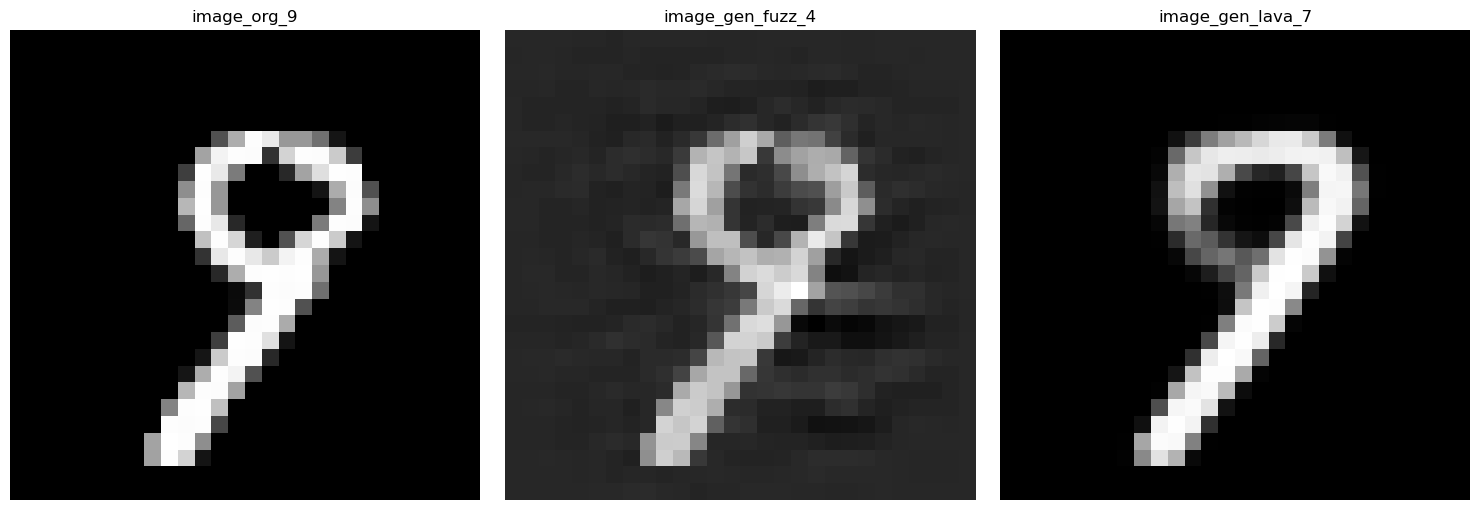

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████      | 171/200 [42:38<07:45, 16.06s/it]

d_fuzz: 0.4260958433151245
d_lava: 1.233340859413147
kl_fuzz: 1.150890827178955
kl_lava: inf
ws_fuzz: 0.0017194284260693502
ws_lava: 0.00013484107003895835
js_fuzz: 0.6038476228713989
js_lava: inf
ce_fuzz: 1.150890588760376
ce_lava: inf
mse_fuzz: 7.1028371166903526e-06
mse_lava: 1.4913068753230618e-06
1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████▎     | 172/200 [42:54<07:28, 16.02s/it]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████▍     | 173/200 [43:10<07:10, 15.94s/it]

1/1 [==============================] - 0s 24ms/step


 87%|███████████████████████████████████▋     | 174/200 [43:26<06:53, 15.92s/it]

1/1 [==============================] - 0s 22ms/step


 88%|███████████████████████████████████▉     | 175/200 [43:43<06:43, 16.15s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████████████████████████████████     | 176/200 [43:59<06:25, 16.07s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████████████████████████████████▎    | 177/200 [44:14<06:07, 15.98s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████▍    | 178/200 [44:30<05:50, 15.93s/it]

1/1 [==============================] - 0s 22ms/step


 90%|████████████████████████████████████▋    | 179/200 [44:46<05:34, 15.94s/it]

1/1 [==============================] - 0s 22ms/step


 90%|████████████████████████████████████▉    | 180/200 [45:02<05:18, 15.91s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████████████████████████████████    | 181/200 [45:19<05:06, 16.15s/it]

1/1 [==============================] - 0s 71ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


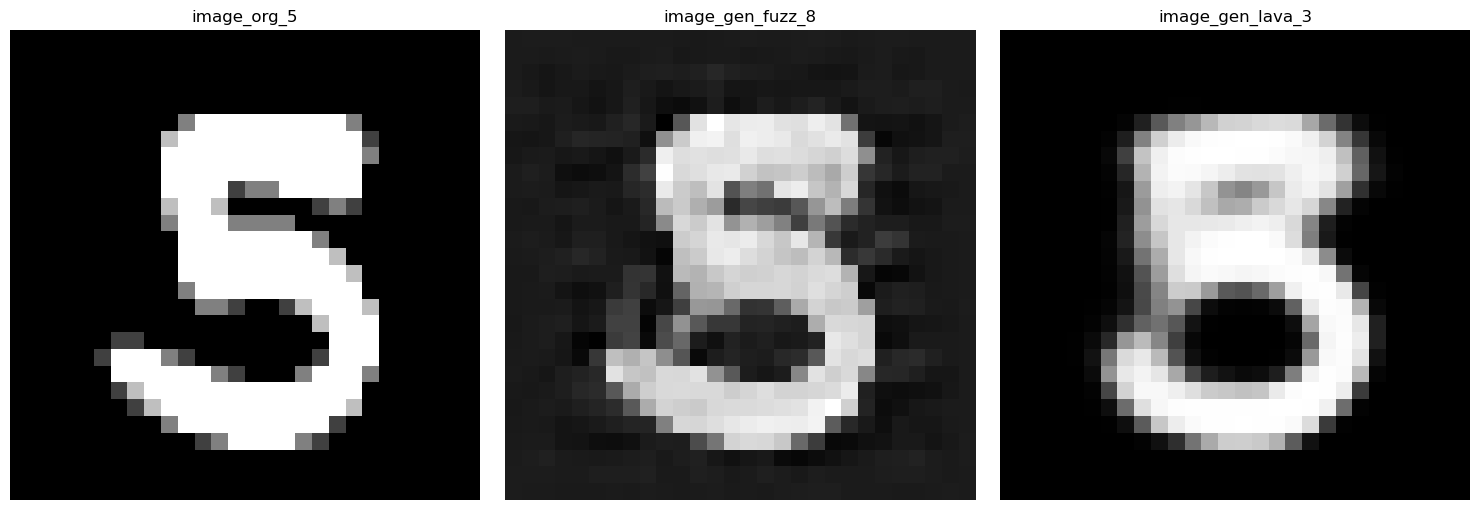

1/1 [==============================] - 0s 22ms/step


 91%|█████████████████████████████████████▎   | 182/200 [45:22<03:40, 12.24s/it]

d_fuzz: 0.19817833602428436
d_lava: 1.7909681797027588
kl_fuzz: 0.526607096195221
kl_lava: inf
ws_fuzz: 0.0010261996156593657
ws_lava: 0.0002626498356736919
js_fuzz: 0.2695636451244354
js_lava: inf
ce_fuzz: 0.526607096195221
ce_lava: inf
mse_fuzz: 1.5734009366497048e-06
mse_lava: 7.928092600195669e-07
1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████▌   | 183/200 [45:38<03:47, 13.38s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████████████████████████████████▋   | 184/200 [45:54<03:46, 14.15s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████████████████████████████████▉   | 185/200 [46:10<03:39, 14.66s/it]

1/1 [==============================] - 0s 22ms/step
Misclassification achieved at iteration 22
1/1 [==============================] - 0s 21ms/step


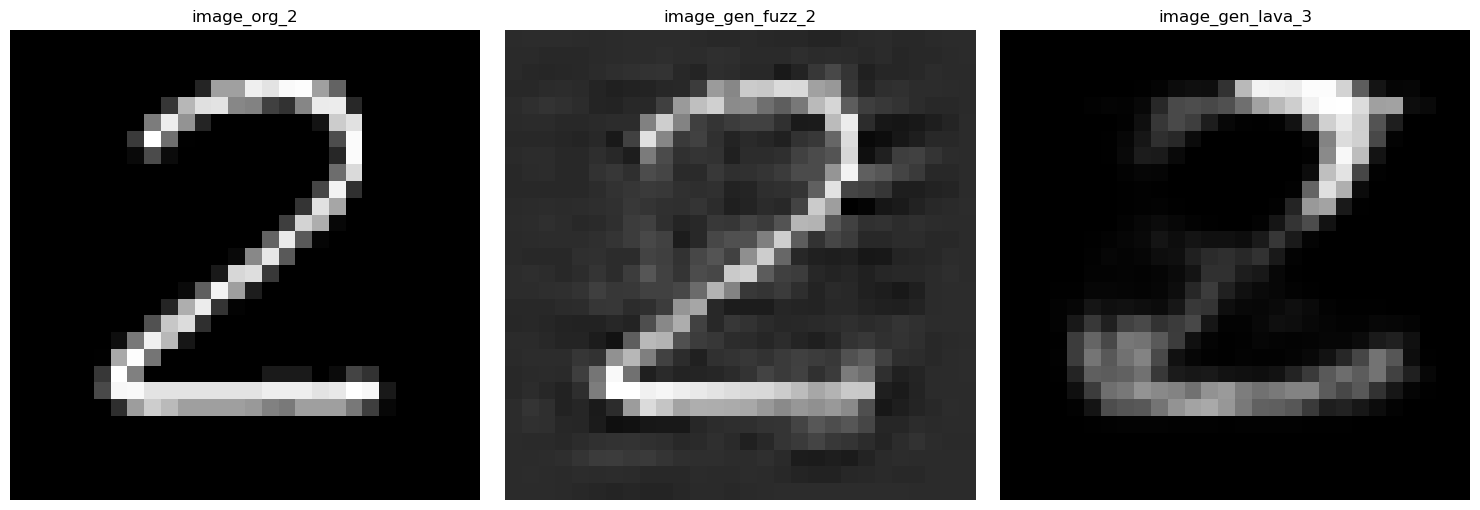

1/1 [==============================] - 0s 21ms/step


 93%|██████████████████████████████████████▏  | 186/200 [46:15<02:48, 12.02s/it]

d_fuzz: 0.2971632778644562
d_lava: 1.8905971050262451
kl_fuzz: 1.2944416999816895
kl_lava: inf
ws_fuzz: 0.0018084489977215471
ws_lava: 0.00046604763490755685
js_fuzz: 0.7113609313964844
js_lava: inf
ce_fuzz: 1.2944416999816895
ce_lava: inf
mse_fuzz: 8.503438039042521e-06
mse_lava: 6.213293545442866e-06
1/1 [==============================] - 0s 22ms/step


 94%|██████████████████████████████████████▎  | 187/200 [46:31<02:51, 13.16s/it]

1/1 [==============================] - 0s 22ms/step


 94%|██████████████████████████████████████▌  | 188/200 [46:48<02:49, 14.15s/it]

1/1 [==============================] - 0s 22ms/step


 94%|██████████████████████████████████████▋  | 189/200 [47:04<02:41, 14.68s/it]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████▉  | 190/200 [47:19<02:30, 15.01s/it]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████▏ | 191/200 [47:35<02:17, 15.25s/it]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████▎ | 192/200 [47:51<02:03, 15.44s/it]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████▌ | 193/200 [48:07<01:49, 15.57s/it]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████▊ | 194/200 [48:23<01:34, 15.80s/it]

1/1 [==============================] - 0s 22ms/step


 98%|███████████████████████████████████████▉ | 195/200 [48:39<01:19, 15.83s/it]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████▏| 196/200 [48:55<01:03, 15.87s/it]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████▍| 197/200 [49:11<00:47, 15.88s/it]

1/1 [==============================] - 0s 22ms/step


 99%|████████████████████████████████████████▌| 198/200 [49:27<00:31, 15.90s/it]

1/1 [==============================] - 0s 22ms/step


100%|████████████████████████████████████████▊| 199/200 [49:43<00:15, 15.91s/it]

1/1 [==============================] - 0s 23ms/step


100%|█████████████████████████████████████████| 200/200 [49:59<00:00, 15.00s/it]


In [10]:
# start
for i in tqdm(range(len(x_view))):

    # calculate fuzz image
    image_org = np.array([view_samples[i]], dtype="float32")
    label_org = view_sample_labels[i]
    image_gen_fuzz = dlfuzz.generate_fuzzy_image(image_org)
    # of shape (28, 28, 1)

    # calculate latent variant image
    x = np.array([h_view[i]])
    y = np.array([y_view_onehot[i]])
    g = gradient_of_x(x, y, xai)
    g_npy = np.squeeze(g.numpy())
    
    # var = 0.5
    # h_lava = get_h_lava_via_one_step(x, g_npy, step=var)
    # image_gen_lava = vae.decoder.predict(h_lava)[0].reshape((28, 28, 1))

    alpha = 0.01  # Learning rate
    num_iterations = 100  # Number of iterations for gradient descent
    [image_gen_lava, prediction] = gradient_descent_generate(h_view[i], y_view_onehot[i], alpha, num_iterations)

    label_fuzz = np.argmax(cnn.predict(np.array([image_gen_fuzz]))[0])
    label_lava = np.argmax(cnn.predict(np.array([image_gen_lava]))[0])

    # List of images and their titles
    images = [image_org, image_gen_fuzz, image_gen_lava]
    titles = [f'image_org_{label_org}', f'image_gen_fuzz_{label_fuzz}', f'image_gen_lava_{label_lava}']

    # Plot the images
    if label_lava != label_org:
        plot_image_comparison(images, titles)

        # in latent space
        # Euclidean distance (L2 norm) 
        h_fuzz = vae.encoder.predict(np.array([image_gen_fuzz.reshape((784,))]))[0]
        d_fuzz = np.linalg.norm(x - h_fuzz)
        d_lava = np.linalg.norm(x - h_lava)
        print(f"d_fuzz: {d_fuzz}\nd_lava: {d_lava}")

        # in image space
        kl_fuzz = kl_divergence(image_org, image_gen_fuzz)
        kl_lava = kl_divergence(image_org, image_gen_lava)
        print(f"kl_fuzz: {kl_fuzz}\nkl_lava: {kl_lava}")

        ws_fuzz = ws_distance(image_org, image_gen_fuzz)
        ws_lava = ws_distance(image_org, image_gen_lava)
        print(f"ws_fuzz: {ws_fuzz}\nws_lava: {ws_lava}")

        js_fuzz = js_divergence(image_org, image_gen_fuzz)
        js_lava = js_divergence(image_org, image_gen_lava)
        print(f"js_fuzz: {js_fuzz}\njs_lava: {js_lava}")

        ce_fuzz = cross_entropy(image_org, image_gen_fuzz)
        ce_lava = cross_entropy(image_org, image_gen_lava)
        print(f"ce_fuzz: {ce_fuzz}\nce_lava: {ce_lava}")

        mse_fuzz = mse_loss(image_org, image_gen_fuzz)
        mse_lava = mse_loss(image_org, image_gen_lava)
        print(f"mse_fuzz: {mse_fuzz}\nmse_lava: {mse_lava}")
        